In [1]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## <a id="2">Importing Dataset</a>


In [2]:
# Importing the dataset
dataset = pd.read_csv('/kaggle/input/inappropriate-text-for-kids-dataset/FinalCombinedDataset.csv')

In [3]:
dataset.sample(10)

,texts,category
70122,sun daily newspaper based lowell massachusetts...,0
52713,someone help remember countries common made ma...,0
58265,8220 user im put sooooo much nut fucking mouth...,1
19651,watch excited isis jihadis getting yezidi sex ...,1
99506,large language models nlp courses courses yall...,0
34309,rt user bruh trash take yo ass back college user,1
37170,friend wife turned sexual interest started fuc...,1
87241,exhibitionist experience part 4 naked grocery ...,1
89052,til un peacekeeper forces primarily composed s...,0
20877,invasive red fire ants confirmed europe first ...,0


In [4]:
dataset.dropna(inplace=True)
dataset.drop_duplicates(inplace=True)

In [5]:
dataset["category"].value_counts()

category
1    64152
0    59364
Name: count, dtype: int64

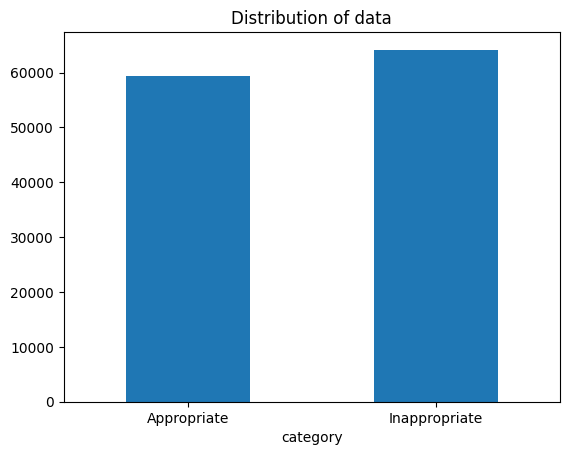

In [6]:
ax = dataset.groupby('category').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Appropriate','Inappropriate'], rotation=0)

In [7]:
dataset.sample(10)

,texts,category
52718,20 fun leprechaun traps kids make,0
58732,nasas sofia finds water moons sunlit side,0
85353,covid19 infections continue rise united states...,0
42521,tuning forks work,0
20174,earlier week worlds largest coin went sale auc...,0
72610,u sent nudes ina relationship nah user pussy b...,1
103461,rt user fuck girl longer 30 min still aint bus...,1
122750,pull pigtails fuck ass,1
727,could cat scuba dive,0
87718,mt everest guide gelji sherpa rescues malaysia...,0


## <a id="4">Analysing the Data</a>
Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

In [8]:
data_appro = []
data_inappro = []

for row in dataset.itertuples():
    
    if row[2] == 0:
        data_appro.append(row[1])
    else:
        data_inappro.append(row[1])

In [9]:
print("Appropriate Texts")
for i in range(10):
    print(data_appro[i])

Appropriate Texts
eight wands tarot card unleashing rockets desire
hitech fabric changes color exposed human touch music
easy red white blue tie dye tshirts perfect 4th july
paintings paul gauguin
new knight rider car works
baby bruno custom blanky
breaking news updates stories southwest connecticut largest newspaper
teeth look like different animals answer questions fun teeth eating game
ariel atom works
harry potter alliteration challenge


In [10]:
print("Inappropriate Texts")
for i in range(10):
    print(data_inappro[i])

Inappropriate Texts
happens delivery guy comes knocking lockdown things delivers leaving let journey find
ive got cure case mondays
space store 19yo petite tattooed asian
working convenience store mature lady
mature japanese wife gets hairy cunt stuffed cock
user better feel love dont even show hoes love lol
rt user user quote funny caption niggas got ta hit side bitch th 8230
blackedraw overfill creampie compilation
shhh dont wake boyfriend
throat cock couch watch football


### Word-Cloud for Appropriate Texts.

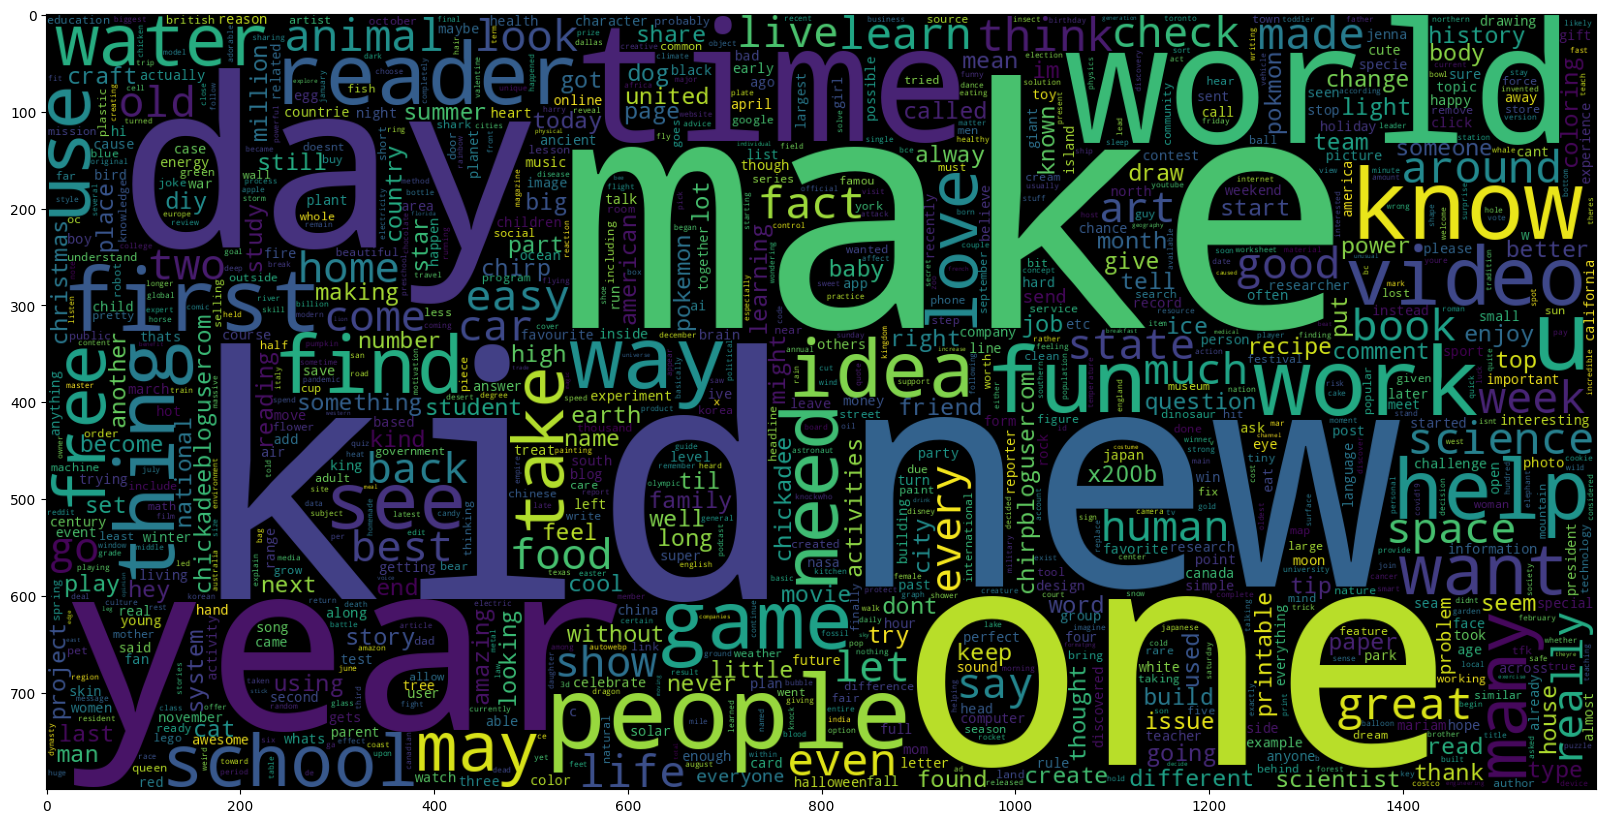

In [11]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_appro))
plt.figure(figsize = (20,20))
plt.imshow(wc)

### Word-Cloud for Inappropriate Texts.

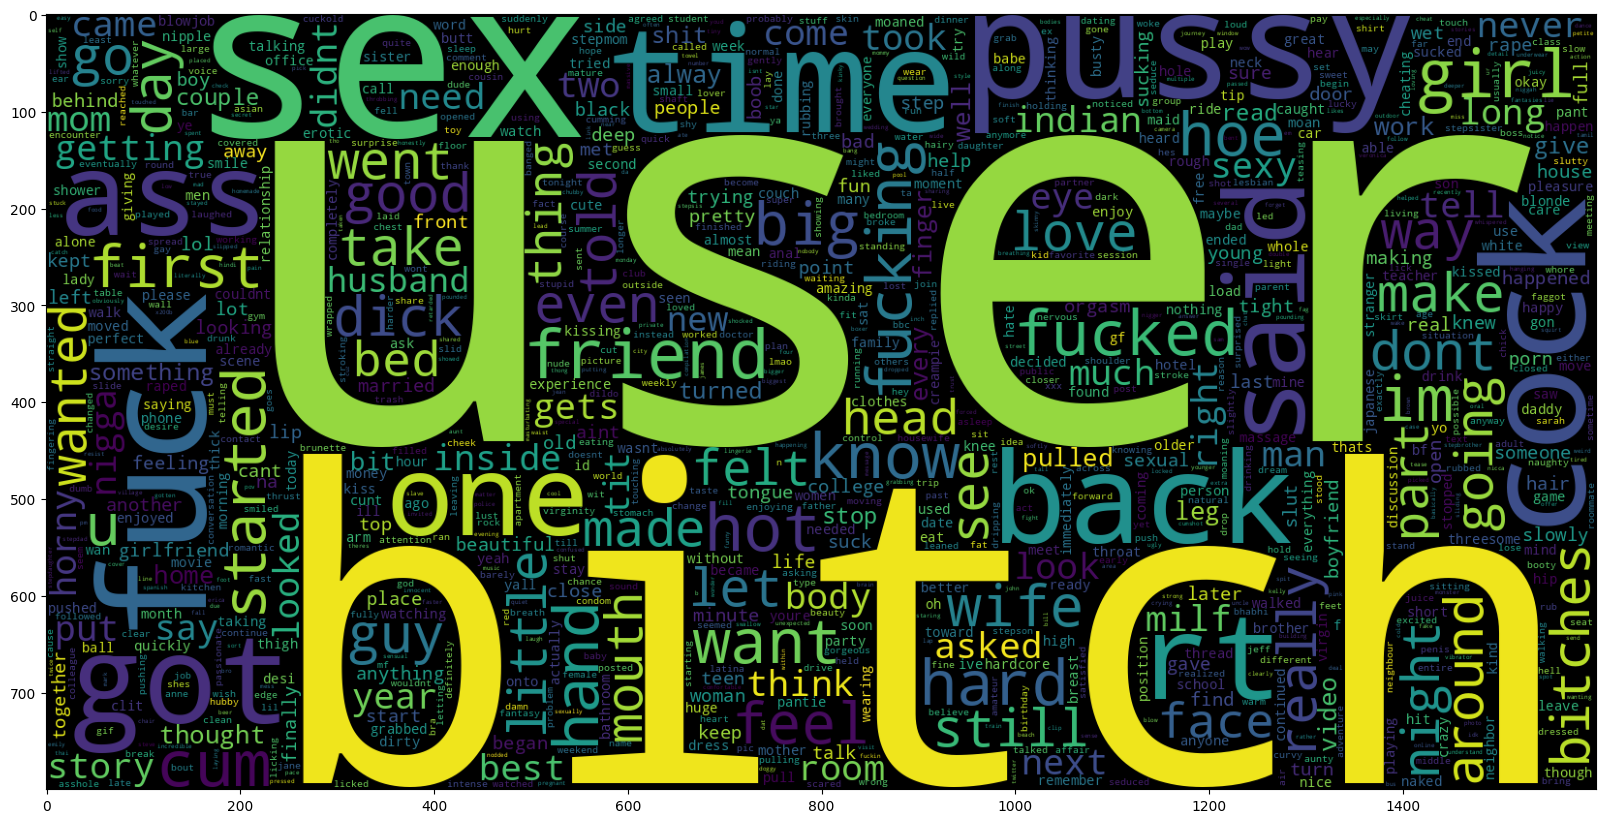

In [12]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_inappro))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## <a id="5">Splitting the Data</a>

Machine Learning models are trained and tested on different sets of data. This is done so to reduce the chance of the model overfitting to the training data, i.e it fits well on the training dataset but a has poor fit with new ones.

**sklearn.model_selection.train_test_split** shuffles the dataset and splits it into train and test dataset.

The Pre-processed Data is divided into 2 sets of data: 
1. **Training Data:** The dataset upon which the model would be trained on. Contains 95% data.
2. **Test Data:** The dataset upon which the model would be tested against. Contains 5% data.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_data, y_data = np.array(dataset['texts']), np.array(dataset['category'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.2, stratify=y_data)
print('Training Size: ', X_train.shape)
print('Testing Size: ', X_test.shape)

Training Size:  (98812,)
Testing Size:  (24704,)


In [15]:
unique_values, counts = np.unique(y_train, return_counts=True)

# Create a dictionary to store the counts for each unique value
value_counts = dict(zip(unique_values, counts))

# Display the result
for value, count in value_counts.items():
    print(f"Value {value}: Count {count}")

Value 0: Count 47491
Value 1: Count 51321


## <a id="6">Creating Word Embeddings using Word2Vec model</a>

**Word embedding** is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. Loosely speaking, word embeddings are **vector representations** of a particular word.

**Word2Vec** was developed by Google and is one of the most popular technique to learn word embeddings using shallow neural network.
Word2Vec can create word embeddings using two methods (both involving Neural Networks): **Skip Gram** and **Common Bag Of Words (CBOW)**.

To learn more about Word2Vec and Word embeddings check out this [article](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa).

In [16]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

**Word2Vec()** function creates and trains the word embeddings using the data passed.

**Training Parameters**
* **size:** The number of dimensions (N) that the Word2Vec maps the words onto. Bigger size values require more training data, but can lead to better (more accurate) models.
* **workers:** Specifies the number of worker threads for training parallelization, to speed up training.
* **min_count:** min_count is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them.

In [17]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 20425
CPU times: user 24.7 s, sys: 180 ms, total: 24.9 s
Wall time: 8.05 s


## <a id="7">Tokenizing and Padding datasets</a>

**Tokenization** is a common task in **Natural Language Processing (NLP)**. It’s a fundamental step in both traditional NLP methods like **Count Vectorizer** and Advanced Deep Learning-based architectures like **Transformers**.

**Tokenization** is a way of separating a piece of text into smaller units called **tokens**. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.

All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model e.g. LSTM, not all the sentences have the same length. We need to have the inputs with the same size, this is where the **padding** is necessary.

**Padding** is the process by which we can add padding tokens at the start or end of a sentence to increase it's length upto the required size. If required, we can also drop some words to reduce to the specified length.


* **Tokenizer:** Tokenizes the dataset into a list of tokens.
* **pad_sequences:** Pads the tokenized data to a certain length.

The **input_length** has been set to 60. This will be the length after the data is tokenized and padded.

In [18]:
max_len = 0
data = []
# w = 0
for ele in dataset["texts"]:
    x = len(ele.split(" "))
    data.append(x)
    if x > max_len:
        max_len = x
#     if x > 312:
#         w += 1

# print(w)
print("Maximum length of sentence: ", max_len)

# Mean
mean_value = sum(data) / len(data)

# Median
sorted_data = sorted(data)
n = len(data)
median_value = (sorted_data[n // 2] + sorted_data[(n - 1) // 2]) / 2 if n % 2 == 0 else sorted_data[n // 2]

# Mode
from collections import Counter
counts = Counter(data)
mode_value = max(counts, key=counts.get)

print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Mode: {mode_value}")


Maximum length of sentence:  3487
Mean: 16.140645746300073
Median: 7.0
Mode: 5


In [19]:
# Defining the model input length.
input_length = 128

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Defining the **Tokenizer** and fitting it on the training data. Here, we are tokenzing the data by spliting it up with the **delimiter space ' '**.

**Args in Tokenizer():**
1. **filters:** Characters to filter out from the sentences to tokenize.
2. **lower:** True/False. Whether to lowerCase the sentence or not.
3. **oov_token:** Out of Vocabulary token to put in for words which aren't in the tokenizer vocab.

Filters and lower has been turned off because we've already done those steps during the preprocessing step.

In [20]:
vocab_length = 40000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 40000


Tokenizing the **X_train and X_test** dataset and padding them to the length **'input_length'**.

The tokenized list is **pre-padded**, i.e padding tokens are added to the start. After padding, the length of the data would be equal to **'input_length'**.

In [21]:
X_train = pad_sequences(tokenizer.texts_to_sequences(list(X_train)), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (98812, 128)
X_test.shape : (24704, 128)


## <a id="8">Creating Embedding Matrix</a>

**Embedding Matrix** is a maxtrix of all words and their corresponding embeddings. We use embedding matrix in an **Embedding layer** in our model to embedded a token into it's vector representation, that contains information regarding that token or word.

We get the embedding vocabulary from the tokenizer and the corresponding vectors from the Embedding Model, which in this case is the Word2Vec model.

**Shape of Embedding matrix** is usually the **Vocab Length * Embedding Dimension.**


In [22]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (40000, 100)


## <a id="9">Creating the Model</a>

There are different approches which we can use to build our classification model. We're going to build a deeplearning **Sequence model.**

**Sequence model** are very good at getting the context of a sentence, since it can understand the meaning rather than employ techniques like counting positive or negative words like in a **Bag-of-Words model**.

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding, Dropout

### Model Architecture

1) **Embedding Layer:** Layer responsible for converting the tokens into their vector representation that is generated by Word2Vec model. We're using the predefined layer from Tensorflow in our model.

**Arguments -**
* **input_dim**: Size of the vocabulary.
* **output_dim**: Dimension of the dense embedding.
* **weights**: Initiazises the embedding matrix.
* **trainable**: Specifies whether the layer is trainable or not.

2) **Bidirectional:** Bidirectional wrapper for RNNs. It means the context are carried from both left to right and right to left in the wrapped RNN layer.

3) **LSTM:** **Long Short Term Memory**, its a variant of **RNN** which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN. 

**Arguments -**
* **units:** Positive integer, dimensionality of the output space.
* **dropout:**  Fraction of the units to drop for the linear transformation of the inputs.
* **return_sequence:** Whether to return the last output in the output sequence, or the full sequence.

4) **Conv1D:** This layer creates a convolution kernel that is convolved with the layer input over a single dimension to produce a tensor of outputs.

**Arguments -**
* **filters:** The dimensionality of the output space (i.e. the number of output filters in the convolution).
* **kernel_size:** Specifies the length of the 1D convolution window.
* **activation:** Specifies the activation function to use. 

5) **GlobalMaxPool1D:** Downsamples the input representation by taking the maximum value over the different dimensions.


6) **Dense:** Dense layer adds a fully connected layer in the model. The argument passed specifies the number of nodes in that layer.

The last dense layer has the activation **"Sigmoid"**, which is used to transform the input to a number between 0 and 1. Sigmoid activations are generally used when we have 2 categories to output in.

In [31]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, return_sequences=True, dropout=0.6)),
        Bidirectional(LSTM(100, return_sequences=True, dropout=0.6)),
        Conv1D(100, 5, activation='relu'),
        Dropout(0.4),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid'),
    ],
    name="Text_Classification_Model")
    return model

### Model Summary

In [32]:
training_model = getModel()
training_model.summary()

Model: "Text_Classification_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 100)          4000000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 128, 200)          160800    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128, 200)          240800    
 onal)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 124, 100)          100100    
                                                                 
 dropout_2 (Dropout)         (None, 124, 100)          0         
                                                                 
 global_max_pooling1d_1 (Gl  (None, 100) 

## <a id="10">Training the Model</a>

### Model Callbacks

**Callbacks** are objects that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

We can use callbacks to write **TensorBoard logs** after every batch of training, periodically save our model, stop training early or even to get a view on internal states and statistics during training.

**ReduceLROnPlateau:** Reduces Learning Rate whenever the gain in performance metric specified stops improving.

* monitor: quantity to be monitored.
* patience: number of epochs with no improvement after which learning rate will be reduced.
* cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.

**EarlyStopping:** Stop training when a monitored metric has stopped improving.

* monitor: Quantity to be monitored.
* min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
* patience: Number of epochs with no improvement after which training will be stopped.

For more details on callbacks, check out the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) on tensorflow.

In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=10)]
# callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)]

### Model Compile

The Model must be compiled to define the **loss, metrics and optimizer**. Defining the proper loss and metric is essential while training the model.

**Loss:** We're using **Binary Crossentropy**. It is used when we have binary output categories. Check out this article on [losses](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/).

**Metric:** We've selected **Accuracy** as it is one of the common evaluation metrics in classification problems when the category data is equal. Learn more about metrics [here](https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/).

**Optimizer:** We're using **Adam**, optimization algorithm for Gradient Descent. You can learn more about Adam [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).

In [35]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We'll now train our model using the **fit** method and store the output learning parameters in **history**, which can be used to plot out the learning curve.

**Arguements:**
* **batch_size:** Number of samples per gradient update. Increasing the batch_size speeds up the training.
* **epochs:** Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided.
* **validation_split:** Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch
* **callbacks:** List of callbacks to apply during training process.
* **verbose:** 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

In [36]:
history = training_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=40,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/40
2780/2780 [==============================] - 74s 24ms/step - loss: 0.1880 - accuracy: 0.9298 - val_loss: 0.1466 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 2/40
2780/2780 [==============================] - 64s 23ms/step - loss: 0.1608 - accuracy: 0.9393 - val_loss: 0.1409 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 3/40
2780/2780 [==============================] - 64s 23ms/step - loss: 0.1507 - accuracy: 0.9423 - val_loss: 0.1293 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 4/40
2780/2780 [==============================] - 64s 23ms/step - loss: 0.1423 - accuracy: 0.9454 - val_loss: 0.1264 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 5/40
2780/2780 [==============================] - 64s 23ms/step - loss: 0.1378 - accuracy: 0.9471 - val_loss: 0.1209 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 6/40
2780/2780 [==============================] - 64s 23ms/step - loss: 0.1332 - accuracy: 0.9488 - val_loss: 0.1170 - val_accuracy: 0.9552 - lr: 0.0010
Epoch 7/40
2780/2780 [========================

In [30]:
# del training_model

## <a id="11">Evaluating Model</a>

Since our dataset is not **skewed**, i.e. it has equal number of **Positive and Negative Predictions**. We're choosing **Accuracy** as our evaluation metric. Furthermore, we're plotting the **Confusion Matrix** to get an understanding of how our model is performing on both classification types.

### Printing out the Learning curve

Learning curves show the relationship between training set size and your chosen evaluation metric (e.g. RMSE, accuracy, etc.) on your training and validation sets. They can be an extremely useful tool when diagnosing your model performance, as they can tell you whether your model is suffering from bias or variance.

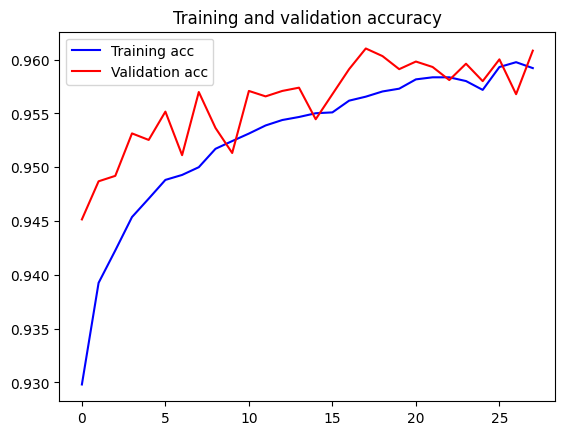

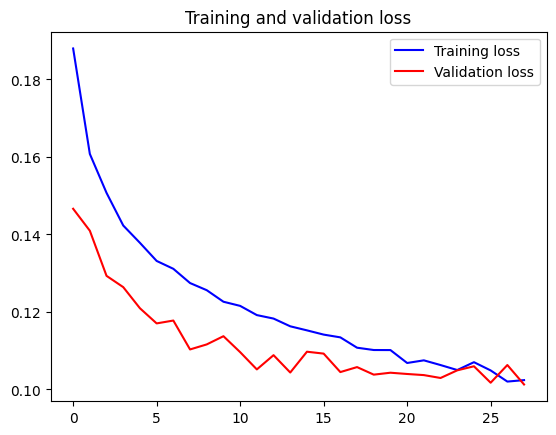

In [37]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

From the training curve we can conclude that our model doesn't have bias nor is it overfitting. The accuracy curve has flattened but is still rising, which means training for more epochs can yield better results.

The Validation loss is lower than the training loss because the dropouts in LSTM aren't active while evaluating the model.

### Confusion Matrix

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Appropriate','Inapprppriate']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

772/772 [==============================] - 8s 9ms/step


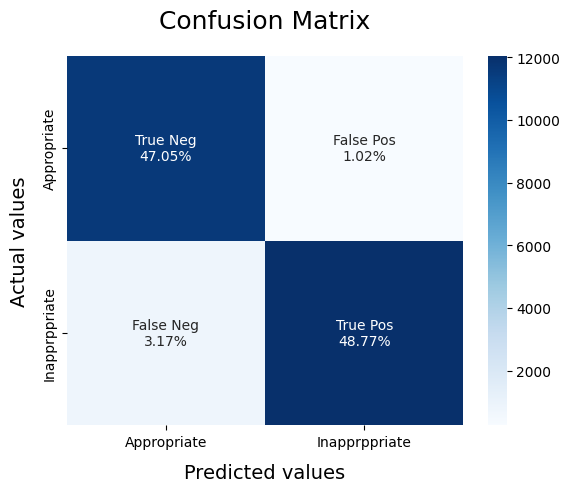

In [39]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the  predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

From the confusion matrix, it can be concluded that the model makes more False Negative predictions than positive. This means that the model is **somewhat biased** towards predicting negative sentiment.

### Classification Report

In [40]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11873
           1       0.98      0.94      0.96     12831

    accuracy                           0.96     24704
   macro avg       0.96      0.96      0.96     24704
weighted avg       0.96      0.96      0.96     24704



## <a id="12">Saving the Model</a>

We're saving the **tokenizer, Word2Vec and Tensorflow model** for use later.

**Word2Vec model** has been saved as 2 different formats:
1. **KeyedVectors:** KeyedVectors do not support further training. On the other hand, by shedding the internal data structures necessary for training, KeyedVectors offer a smaller RAM footprint and a simpler interface.
2. **Full Word2Vec Model:** The Full Word2Vec model contains the model state to enable further training. Saving in this format enables us to update the Vectors later.

In [47]:
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-Embedding-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-Embedding-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('BiLSTM_Classifier')
training_model.save('BiLSTM_INAPPRO_TEXT_CLASSIFIER.h5')
training_model.save_weights("Model Weights/weights")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
import tensorflow as tf

tf.saved_model.save(training_model, "BiLSTM_TEXT_Classifier_using_tf")

In [42]:
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
import pickle

# Loading the saved tokenizer and model
with open("/kaggle/working/Tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)
loaded_model = load_model("/kaggle/working/BiLSTM_INAPPRO_TEXT_CLASSIFIER.h5")

In [43]:
# Example input data
input_text = ["She is a bitch", "she is a good girl"]

# Tokenize and pad sequences
sequence = tokenizer.texts_to_sequences(input_text)
padded_sequence = pad_sequences(sequence, maxlen=128)

In [44]:
result = loaded_model.predict(padded_sequence)
# Converting prediction to reflect the sentiment predicted.
result = np.where(result>=0.5, 1, 0)
result

1/1 [==============================] - 1s 1s/step


array([[1],
       [0]])